# This notebook contains the analysis scripts for the blog post about data jobs in Europe:
## https://methodmatters.github.io/data-jobs-europe-2

In [1]:
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [15, 10]
sns.set(style='darkgrid')

In [2]:
# note: you'll need matplot lib >= 3.4
import matplotlib
matplotlib.__version__


'3.4.1'

## This data file is the result of the Skills-ML analysis
## It uses the fuzzy search in Skills-ML to extract the O*NET skills
## from the English language job descriptions

In [5]:
# read in the skills classification database:
# change in_dir to the location that you've saved the file
in_dir = '../Data/'
with open(in_dir + 'fuzzy_onet_df.pickle', 'rb') as handle:
    fuzzy_onet_df = pickle.load(handle)
fuzzy_onet_df.shape

(32148, 4)

In [6]:
# remove some skills that are frequently extracted but are not correct
# e.g. science is tagged frequently because of data science...
terms_to_drop = ['science', 'self', 'scheme', 'player', 'levels', 'smart']
onet_for_plot = fuzzy_onet_df.drop_duplicates()
onet_for_plot = onet_for_plot[~onet_for_plot.onet_skill_name.isin(terms_to_drop)]
onet_for_plot.shape

(17609, 4)

In [7]:
onet_for_plot.head()

,confidence,document_id,matched_skill_identifier,onet_skill_name
1,100,c6d6dd9bfda01c04aaee353b9614f2c0,43232405-R,r
2,100,c6d6dd9bfda01c04aaee353b9614f2c0,43232405-Python,python
3,100,c6d6dd9bfda01c04aaee353b9614f2c0,2.C.3.c,design
7,100,ee883b2f81fd104f84b8773b10a51e64,43232610-ImPACT,impact
8,100,ee883b2f81fd104f84b8773b10a51e64,2.B.3.e,programming


# 1. Analysis of extracted skills from job description text (ml-skills)

In [8]:
# function to produce the frequency plots
def plot_top_categories(df_f, col_f, cutoff_f, x_axis_label_f, y_axis_label_f, title_f, *args, **kwargs):
    plot_out_dir_f = kwargs.get('plot_out_dir_f', None)
    image_file_title_f = kwargs.get('image_file_title_f', None)
    agg_df_f = df_f[col_f].value_counts().to_frame().reset_index()
    agg_df_select_f = agg_df_f[agg_df_f[col_f] > cutoff_f]
    ax = sns.barplot(y="index", x=f"""{col_f}""", 
                     data=agg_df_select_f)
    ax.bar_label(ax.containers[0])
    ax.set(xlabel=f"""{x_axis_label_f}""")  
    ax.set(ylabel=f"""{y_axis_label_f}""")  
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.set_title(f"""{title_f}""", fontsize = 25)
    # save out the picture (optional) to a file
    if plot_out_dir_f and image_file_title_f:
        plt.tight_layout()
        fig = ax.get_figure()
        fig.savefig(plot_out_dir_f + f"""{image_file_title_f}""" + '.png'  , dpi=250) 

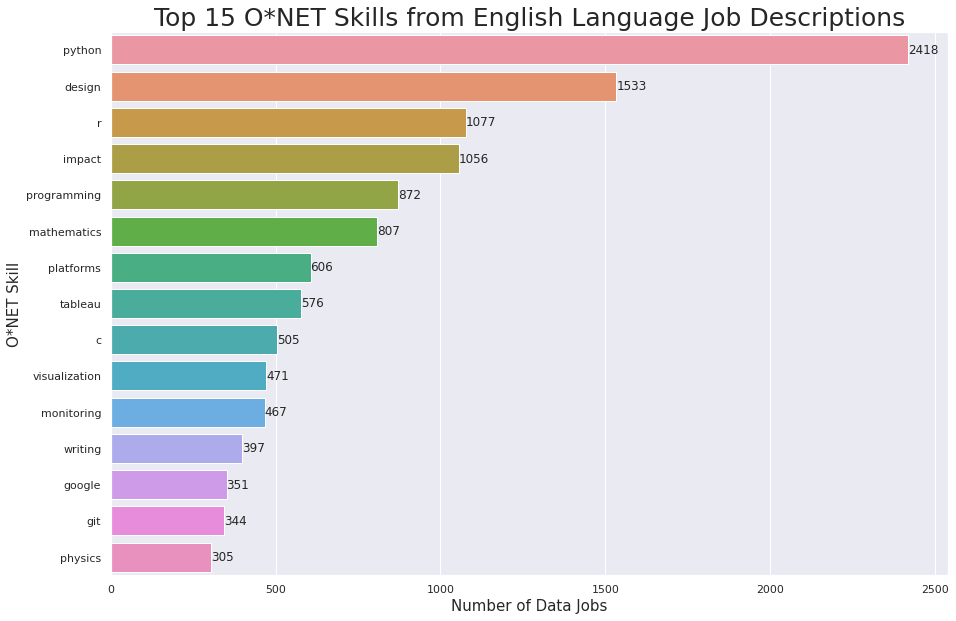

In [9]:
# plot top extracted O*NET skills
plot_top_categories(df_f = onet_for_plot, 
                    col_f = 'onet_skill_name', 
                    cutoff_f = 300, 
                    x_axis_label_f = 'Number of Data Jobs', 
                    y_axis_label_f = 'O*NET Skill',
                    title_f = 'Top 15 O*NET Skills from English Language Job Descriptions')

# 2. Cluster Map with the O*NET Skills

In [10]:
# read in a simplified dataframe with the job id and the job function:
with open(in_dir + 'omnibus_jobs_subset.pickle', 'rb') as handle:
    omnibus_jobs_df = pickle.load(handle)
omnibus_jobs_df.shape

(6590, 2)

In [11]:
omnibus_jobs_df.head()

,job_id,job_function
0,c6d6dd9bfda01c04aaee353b9614f2c0,data analyst
1,ee883b2f81fd104f84b8773b10a51e64,data scientist
2,91314f5731903275839b2f9ab95d5e08,data analyst
3,be021587a7a2527dbebba4203b8dedd9,machine learning engineer
4,b9d14f9a76c502c9c921ada2948fc963,data engineer


In [12]:
# function to take O*NET codes df and data role df (e.g. data scientist, etc.)
# and return the aggregated matrix for the cluster map algorithm
def subset_cleaned_skills_onet(onet_long_df, threshold_f, orig_df_f, job_fn_col_f, terms_to_drop_f):
    # delete duplicate skill ids for a given job id
    fuzzy_wide_f = onet_long_df.drop_duplicates()
    # pivot long-to-wide 
    # https://stackoverflow.com/questions/69846753/pivot-long-form-categorical-data-by-group-and-dummy-code-categorical-variables
    fuzzy_wide_bool_f = fuzzy_wide_f.reset_index().pivot_table(index=['document_id'], 
                             columns='onet_skill_name',
                             values='index',
                             aggfunc='nunique', fill_value=0).astype(bool).astype(int)
    # make a column for total number of extracted keywords
    fuzzy_wide_bool_f['total_keywords'] = fuzzy_wide_bool_f.sum(axis=1)
    print('average number of total keywords')
    print(fuzzy_wide_bool_f['total_keywords'].mean())
    print('max number of total keywords')
    print(fuzzy_wide_bool_f['total_keywords'].max())
    print('min number of total keywords')
    print(fuzzy_wide_bool_f['total_keywords'].min())
    # subset columns - only those that appear more times than threshold
    fuzzy_wide_bool_f = fuzzy_wide_bool_f.loc[:, fuzzy_wide_bool_f.sum(axis=0) > threshold_f]
    # subset columns - skills that exist but aren't being coded correctly here...
    fuzzy_wide_bool_f = fuzzy_wide_bool_f.loc[:,~fuzzy_wide_bool_f.columns.isin(terms_to_drop_f)]
    # put document id back into fuzzy wide bool as a proper column
    fuzzy_wide_bool_f = fuzzy_wide_bool_f.reset_index(drop = False)
    # add job function from original df
    # drop columns not needed for aggregation & cluster map
    fuzzy_job_fn_f = pd.merge(orig_df_f[['job_id', job_fn_col_f ]], 
                            fuzzy_wide_bool_f, left_on = 'job_id', right_on = 'document_id', 
                            how = 'inner').drop(['document_id', 'job_id', 'total_keywords'], axis = 1)
    agg_df_f = fuzzy_job_fn_f.groupby(['job_function']).mean() * 100
    return(agg_df_f)

In [13]:
# apply the function to our data
onet_agg_df = subset_cleaned_skills_onet(onet_long_df =  fuzzy_onet_df, 
                           threshold_f = 50, 
                           orig_df_f = omnibus_jobs_df, 
                           job_fn_col_f = 'job_function',
                           # some of the skills aren't perfectly coded
                           # the social media skills come up because the job ads
                           # say things like "check us out on Twitter!"
                           # not because Twitter is a useful skill for the job... 
                           terms_to_drop_f = ['science', 'self', 'scheme', 
                                              'player', 'levels', 'smart',
                                             'j', 'rules', 'certain', 
                                              'reduce', 'stage', 'derive',
                                              'twitter', 'linkedin', 'facebook'])

average number of total keywords
5.944961446423823
max number of total keywords
21
min number of total keywords
1


In [14]:
# this is the final matrix
# passed to the clustermap algorithm
onet_agg_df.head()

,apache spark,biology,c,chemistry,coordination,critical thinking,design,elasticsearch,english language,git,google,google analytics,impact,javascript,linux,mathematics,microsoft excel,microsoft office,mongodb,monitoring,mysql,nosql,oracle,physics,platforms,postgresql,programming,programming languages,python,r,salesforce,sap,sas,skill,speaking,spss,tableau,tables,time management,transportation,troubleshooting,unix,visualization,writing
job_function,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
data analyst,0.085837,0.600858,6.781116,1.459227,2.403433,3.261803,29.270386,0.686695,2.145923,2.489270,8.755365,5.751073,25.407725,1.630901,0.858369,15.793991,5.665236,5.321888,0.772532,12.446352,2.575107,0.686695,4.120172,2.746781,10.901288,1.545064,11.502146,4.120172,33.476395,22.145923,3.605150,5.665236,6.866953,4.721030,1.802575,3.175966,25.579399,6.351931,3.862661,2.575107,1.802575,0.257511,13.648069,11.587983
data engineer,5.377456,1.034126,12.099276,1.034126,0.930714,1.240951,55.118925,6.514995,1.964840,12.409514,12.306101,1.240951,24.301965,4.756980,8.066184,10.031024,0.206825,0.723888,5.067218,15.615305,7.445708,13.650465,5.894519,3.205791,23.578077,7.445708,25.956567,7.962771,74.974147,14.374354,1.654602,2.171665,2.275078,4.860393,3.722854,0.206825,11.995863,2.171665,1.447777,3.412616,4.756980,2.895553,8.686660,10.341262
data scientist,1.166667,2.750000,13.500000,2.500000,1.583333,2.250000,37.833333,1.750000,1.166667,11.166667,7.166667,1.083333,33.916667,2.416667,3.333333,35.833333,0.500000,0.833333,1.083333,9.500000,1.416667,4.583333,1.666667,15.916667,14.666667,1.416667,27.833333,9.750000,78.666667,49.250000,0.333333,1.333333,6.666667,6.916667,1.416667,2.250000,13.333333,1.166667,1.916667,1.416667,0.583333,1.583333,17.916667,10.250000
machine learning engineer,1.165501,3.030303,34.265734,1.165501,0.699301,1.631702,47.785548,0.932401,3.729604,14.219114,10.256410,0.000000,27.505828,4.662005,9.790210,22.377622,0.000000,0.000000,1.864802,13.286713,0.932401,5.594406,0.233100,11.888112,17.482517,2.797203,35.664336,6.759907,83.682984,20.745921,0.466200,3.496503,0.466200,4.895105,1.165501,0.000000,0.466200,0.233100,1.631702,1.631702,2.331002,4.428904,3.030303,9.090909


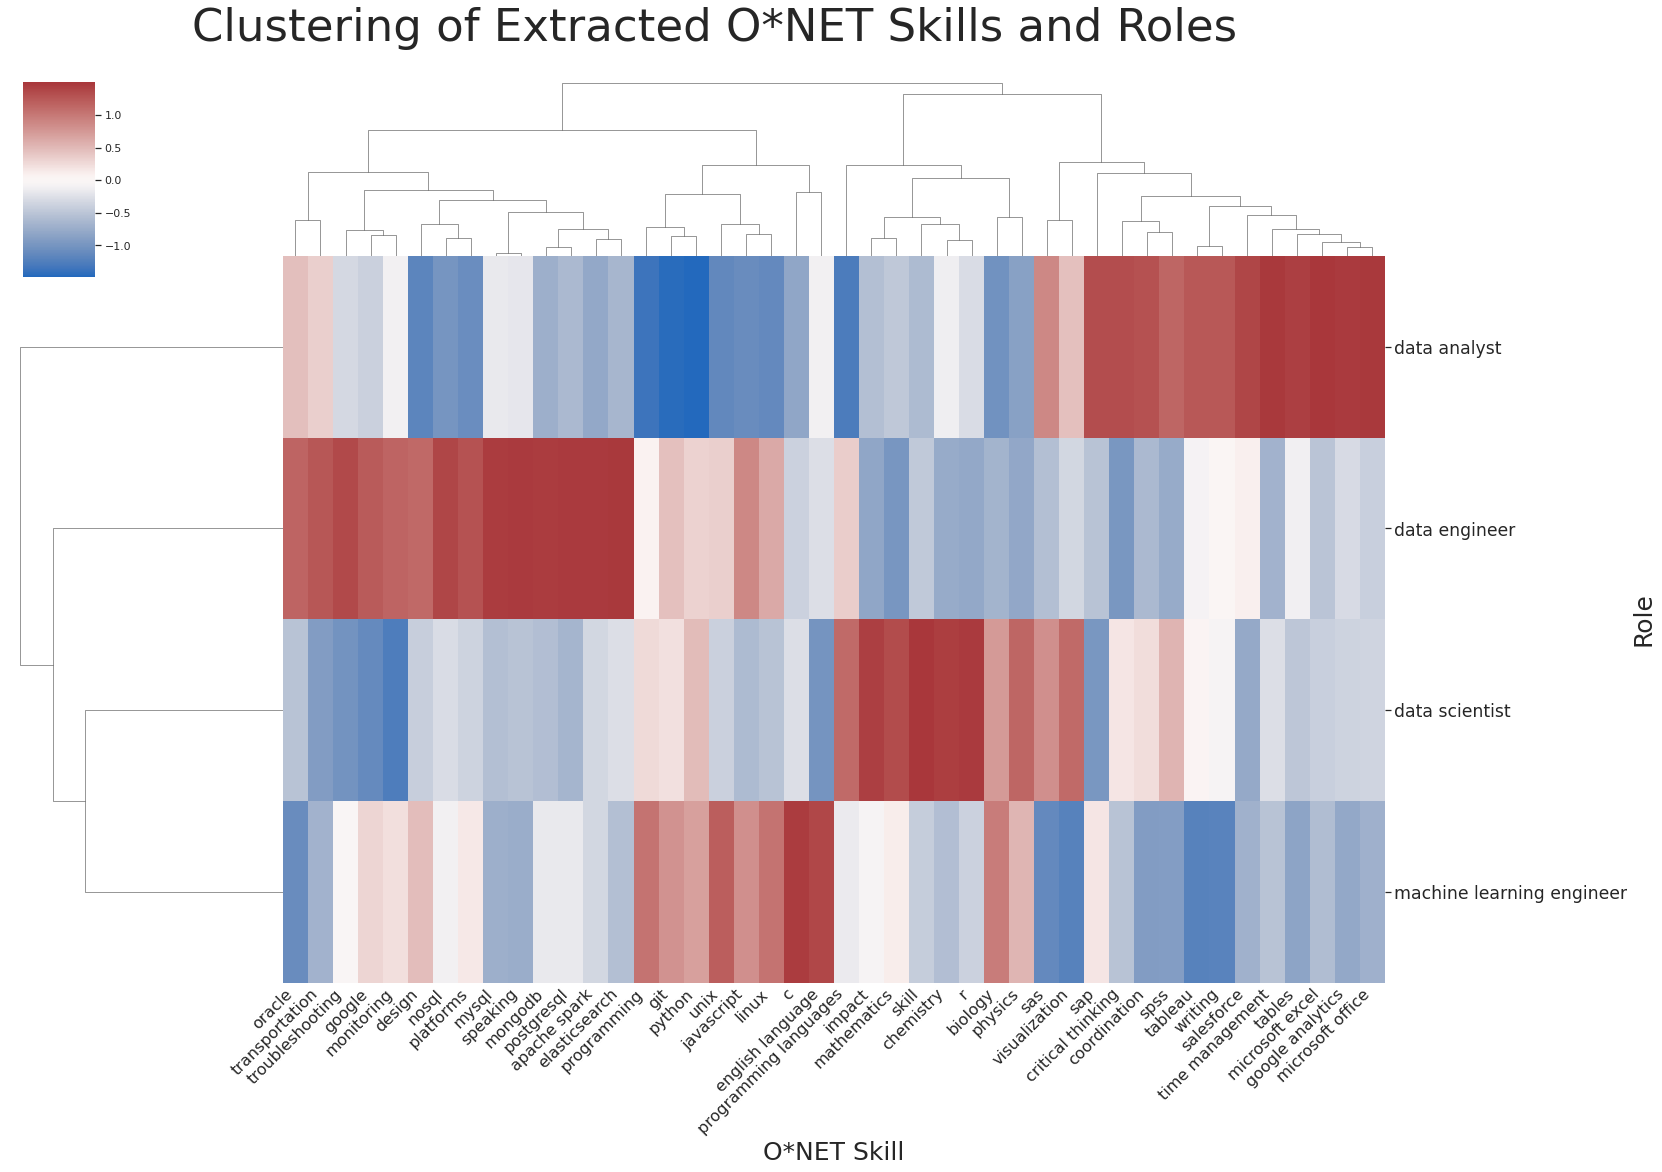

In [16]:
# pass our aggregated data to the clustermap algorithm
# and make the final plot
g = sns.clustermap(onet_agg_df, z_score = 1, figsize=(20, 15), cmap= "vlag") 
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), 
         rotation=45, 
         horizontalalignment='right', 
         verticalalignment='center_baseline',
         fontsize='x-large')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize='x-large') 
g.fig.suptitle(t = 'Clustering of Extracted O*NET Skills and Roles', 
               fontsize = 45,
              y = 1.05)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
ax = g.ax_heatmap
ax.set_xlabel("O*NET Skill", fontsize= 25)
ax.set_ylabel("Role", fontsize=25);